# Practice extracting data from pdf

In [736]:
import xlwings as xw
import pandas as pd
import matplotlib.pyplot as plt


from __future__ import annotations
from dataclasses import dataclass
import json
from typing import Any, Union, Optional
from papermodels.paper import annotations, fdf, plot
from papermodels.db.data_model import Annotation
from shapely.geometry import GeometryCollection, Polygon, Point
from shapely.ops import voronoi_diagram
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Polygon
from shapely import wkt, voronoi_polygons

from papermodels.paper.annotations import scale_annotations, filter_annotations, annotations_to_shapely

from shapely.geometry import MultiPolygon

In [737]:
def load_annotations(file_list: list[str], scale_factor: Optional[float] = None, labels: Optional[list[str]] = None) -> dict[str, list[Annotation]]:
    
    """
    Returns a dict whose keys are each file name in 'file_list' and values are a list
    of annotations found in the files. If 'scale_factor' is specified, the resulting
    annotation geometries are scaled by 'scale_factor'.
    'labels' - Labels to be used as dict keys for each file in 'file_list'
    
    """
    annot_data = {}
    for idx, file_name in enumerate(file_list):
        annots = fdf.read_annotations(file_name)
        if scale_factor is not None:
            annots = annotations.scale_annotations(annots, scale=scale_factor)
        if labels is not None:
            if len(labels) != len(file_list):
                raise ValueError(f"Length of labels must match length file list. {len(file_list)=}, {len(labels)=}")
            annot_data.update({labels[idx]: annots})
    return annot_data

def calculate_center_of_mass(lengths, coords):
    """Calculates the center of mass for a set of walls."""
    total_length = sum(lengths)
    com = sum(length * coord for length, coord in zip(lengths, coords)) / total_length
    return com

def calculate_normalized_lengths(lengths):
    """Calculates normalized lengths."""
    total_length = sum(lengths)
    return [length / total_length for length in lengths]

def calculate_m_torsion(lengths, longest_dimension):
    """Calculates torsion values for walls."""
    return [0.1 * longest_dimension for _ in lengths]

def calculate_rigidity(lengths, coords, com):
    """Calculates rigidity-related values for walls."""
    d_list = [abs(com - coord) for coord in coords]
    kdx_list = [length * d**2 for length, d in zip(lengths, d_list)]
    Jp = sum(kdx_list)
    return d_list, Jp

def calculate_v_total(normalized_lengths, torsion_list, k_list, Jp):
    """Calculates the total shear distribution for walls."""
    return [
        norm_length + (tor * k) / Jp
        for norm_length, tor, k in zip(normalized_lengths, torsion_list, k_list)
    ]

def plot_shear_wall_layout(ax, x_list, y_list, lengths, color, label_prefix):
    """Plots shear walls in a given direction."""
    for i, (x, y, length) in enumerate(zip(x_list, y_list, lengths)):
        if color == 'blue':  # Vertical (north-south)
            ax.plot([x, x], [y, y + length], label=f"{label_prefix} Wall {i+1}", color=color)
        else:  # Horizontal (east-west)
            ax.plot([x, x + length], [y, y], label=f"{label_prefix} Wall {i+1}", color=color)


def calculate_center_of_mass_with_floor(weights, centers, floor_weight, floor_center):
    """
    Calculates the center of mass including wall weights and floor diaphragm weight.
    
    Parameters:
    - weights: List of wall weights.
    - centers: List of wall center coordinates (X or Y).
    - floor_weight: Total weight of the floor diaphragm.
    - floor_center: Coordinate of the floor diaphragm center (X or Y).
    
    Returns:
    - Combined center of mass (X or Y coordinate) including the floor diaphragm.
    """
    # Total weight (walls + floor)
    total_wall_weight = sum(weights)
    total_weight = total_wall_weight + floor_weight
    
    # Center of mass for walls
    wall_com = sum(weight * center for weight, center in zip(weights, centers)) / total_wall_weight
    
    # Combined center of mass (walls + floor)
    combined_com = (total_wall_weight * wall_com + floor_weight * floor_center) / total_weight
    return combined_com


def calculate_wall_weights(lengths, heights, weight_per_unit_area=0.48):
    """
    Calculates the weight of walls based on their length, height, and weight per unit area.
    
    Parameters:
    - lengths: List of wall lengths.
    - heights: List of wall heights.
    - weight_per_unit_area: Weight per unit area (default is 0.48 kPa).
    
    Returns:
    - List of wall weights.
    """
    wall_weights = []
    for length, height in zip(lengths, heights):
        area = length * height  # Area of the wall
        weight = area * weight_per_unit_area  # Weight of the wall
        wall_weights.append(weight)
    return wall_weights


def calculate_center_of_rigidity_simple(lengths, heights, coords):
    """
    Calculates the center of rigidity assuming stiffness is proportional to length × height.
    
    Parameters:
    - lengths: List of wall lengths.
    - heights: List of wall heights.
    - coords: List of coordinates (X or Y).
    
    Returns:
    - Center of rigidity (X or Y coordinate).
    """
    stiffnesses = [length * height for length, height in zip(lengths, heights)]
    total_stiffness = sum(stiffnesses)
    rigidity_center = sum(stiffness * coord for stiffness, coord in zip(stiffnesses, coords)) / total_stiffness
    return rigidity_center

def calculate_wall_centers(start_coords, lengths, axis='y'):
    """
    Calculates the center coordinates for walls.
    
    Parameters:
    - start_coords: List of starting coordinates (X or Y).
    - lengths: List of wall lengths.
    - axis: 'x' or 'y', indicating which axis the wall centers are calculated for.
    
    Returns:
    - List of center coordinates.
    """
    centers = [start + (length / 2) for start, length in zip(start_coords, lengths)]
    return centers

def calculate_center_of_rigidity_relative(lengths, heights, centers):
    """
    Calculates the center of rigidity using relative rigidity approach.
    
    Parameters:
    - lengths: List of wall lengths.
    - heights: List of wall heights.
    - centers: List of center coordinates (X or Y).
    
    Returns:
    - Center of rigidity (X or Y coordinate).
    """
    relative_stiffnesses = [length * height for length, height in zip(lengths, heights)]
    total_stiffness = sum(relative_stiffnesses)
    rigidity_center = sum(stiffness * center for stiffness, center in zip(relative_stiffnesses, centers)) / total_stiffness
    return rigidity_center


project_dir = pathlib.Path.cwd() 

files = [
    project_dir/"floor_data_r7.fdf"
]


In [738]:
files

[WindowsPath('H:/_Personal/01_Projects/pycode/Wood_frame_Shear_Wall_Tools_Development/floor_data_r7.fdf')]

In [739]:
## -----------------------------------------------------------------------------------
# Understand the scaling factor from inchs to m
## -----------------------------------------------------------------------------------
# scaling_factor = (1/72)*(1/(1/8))

# To convert it to meter
scaling_factor = 0.002822222*10
scaling_factor


0.02822222

In [740]:
annots_by_diaphragm = load_annotations(file_list = files, scale_factor= scaling_factor, labels=['diaphragm'])
annots_by_diaphragm

{'diaphragm': [Annotation(object_type='Line', vertices=[7.03746455698, 35.532875646579996, 7.03746455698, 27.709645218138], page='0', text=None, line_color=(0.0, 0.0, 1.0), line_weight=2.0, fill_color=(1, 1, 1), line_type=None, line_opacity=None, fill_opacity=None, matrix=[1.0, 0.0, 0.0, 1.0, -242.859, -975.3379]),
  Annotation(object_type='Line', vertices=[48.25996797778, 43.491569908799995, 48.25996797778, 35.668342302579994], page='0', text=None, line_color=(0.0, 0.0, 1.0), line_weight=2.0, fill_color=(1, 1, 1), line_type=None, line_opacity=None, fill_opacity=None, matrix=[1.0, 0.0, 0.0, 1.0, -1703.499, -1257.339]),
  Annotation(object_type='Line', vertices=[41.81175515218, 28.34636954578, 48.364418414, 28.34636954578], page='0', text=None, line_color=(0.0, 1.0, 0.0), line_weight=3.0, fill_color=(1, 1, 1), line_type=None, line_opacity=None, fill_opacity=None, matrix=[1.0, 0.0, 0.0, 1.0, -1474.019, -996.899]),
  Annotation(object_type='Line', vertices=[15.40933212, 41.96754180658, 15

# Floor diaphragm data

[Annotation(object_type='Polygon', vertices=[6.6920245841799995, 43.7150898912, 41.16603075857999, 43.68119500498, 41.1547700928, 45.97918926848, 49.1202094656, 46.04387459672, 49.1202094656, 21.708531624, 35.27546077796, 21.8643182784, 35.255169001780004, 28.4615444256, 7.0645578881799995, 28.515759310219998], page='0', text=None, line_color=(1.0, 0.0, 0.0), line_weight=1.0, fill_color=(1, 1, 1), line_type=None, line_opacity=None, fill_opacity=None, matrix=[1.0, 0.0, 0.0, 1.0, -231.619, -763.7001])]

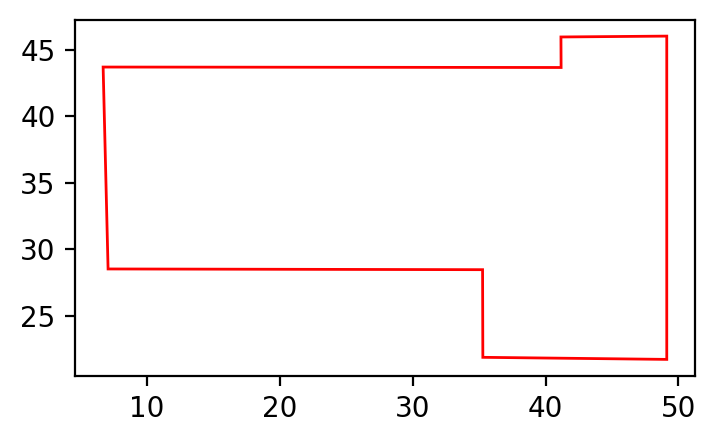

In [741]:
floor_properties={'line_weight': 1.0}
for label, annots in annots_by_diaphragm.items():
    # panel_area_annots = annotations.filter_annotations(annots, panel_area_properties)
    floor_annots = annotations.filter_annotations(annots, floor_properties)

floor_annots
plot.plot_annotations(floor_annots, size=4, dpi=200)


floor_annots

# Floor centroid calculation

In [742]:
from shapely.geometry import MultiPolygon

# Filter annotations for floor geometry
floor_properties = {'line_weight': 1.0}
for label, annots in annots_by_diaphragm.items():
    floor_annots = annotations.filter_annotations(annots, floor_properties)

# Convert the floor annotations to Shapely geometry
floor_shapes = annotations.annotations_to_shapely(floor_annots)

# Combine the floor shapes into a MultiPolygon
floor_geometry = MultiPolygon(floor_shapes)

# Calculate the centroid of the floor
floor_centroid_x = floor_geometry.centroid.x
floor_centroid_y = floor_geometry.centroid.y

# Output the centroid
print(f"Floor Centroid: ({floor_centroid_x:.2f}, {floor_centroid_y:.2f})")


Floor Centroid: (30.17, 34.97)


# North South direction wall data

[Annotation(object_type='Line', vertices=[7.03746455698, 35.532875646579996, 7.03746455698, 27.709645218138], page='0', text=None, line_color=(0.0, 0.0, 1.0), line_weight=2.0, fill_color=(1, 1, 1), line_type=None, line_opacity=None, fill_opacity=None, matrix=[1.0, 0.0, 0.0, 1.0, -242.859, -975.3379]),
 Annotation(object_type='Line', vertices=[48.25996797778, 43.491569908799995, 48.25996797778, 35.668342302579994], page='0', text=None, line_color=(0.0, 0.0, 1.0), line_weight=2.0, fill_color=(1, 1, 1), line_type=None, line_opacity=None, fill_opacity=None, matrix=[1.0, 0.0, 0.0, 1.0, -1703.499, -1257.339]),
 Annotation(object_type='Line', vertices=[15.40933212, 41.96754180658, 15.40933212, 36.323408251], page='0', text=None, line_color=(0.0, 0.0, 1.0), line_weight=2.0, fill_color=(1, 1, 1), line_type=None, line_opacity=None, fill_opacity=None, matrix=[1.0, 0.0, 0.0, 1.0, -539.5, -1280.55]),
 Annotation(object_type='Line', vertices=[35.93588894818, 42.760021744179994, 35.93588894818, 36.61

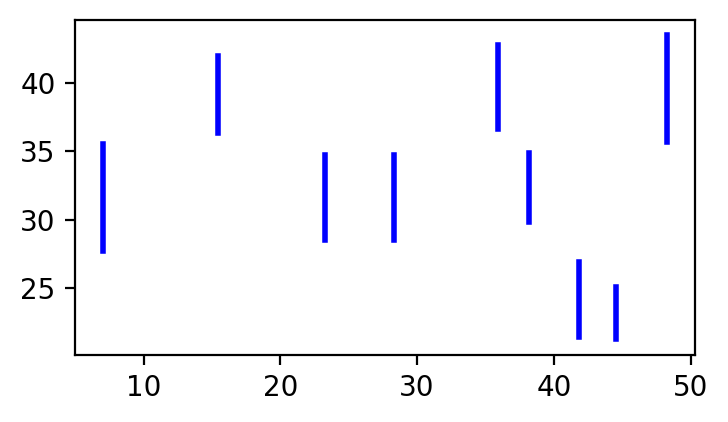

In [743]:
ns_sw_properties={'line_weight': 2.0}
for label, annots in annots_by_diaphragm.items():
    # panel_area_annots = annotations.filter_annotations(annots, panel_area_properties)
    ns_sw_annots = annotations.filter_annotations(annots, ns_sw_properties)

ns_sw_annots
plot.plot_annotations(ns_sw_annots, size=4, dpi=200)


ns_sw_annots

In [744]:
## -----------------------------------------------------------------------------------
# Change the origin of the diaphragm
## -----------------------------------------------------------------------------------
# scale_diaphragm = scale_annotations(annots = opening_area_annots, scale = 1 , paper_origin = (8.5*scaling_factor,34.5*scaling_factor))
# scale_diaphragm = scale_annotations(annots = opening_area_annots, scale = 1 , paper_origin = (8.5,34.5))
scale_diaphragm = scale_annotations(annots = ns_sw_annots, scale = 1 , paper_origin = (0,0))
# plot.plot_annotations(scale_diaphragm, size=6, dpi=200)

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

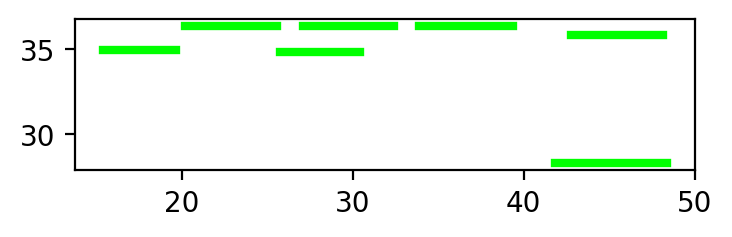

In [745]:
ew_sw_properties={'line_weight': 3.0}
for label, annots in annots_by_diaphragm.items():
    # panel_area_annots = annotations.filter_annotations(annots, panel_area_properties)
    ew_sw_annots = annotations.filter_annotations(annots, ew_sw_properties)

ew_sw_annots
plot.plot_annotations(ew_sw_annots, size=4, dpi=200)

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

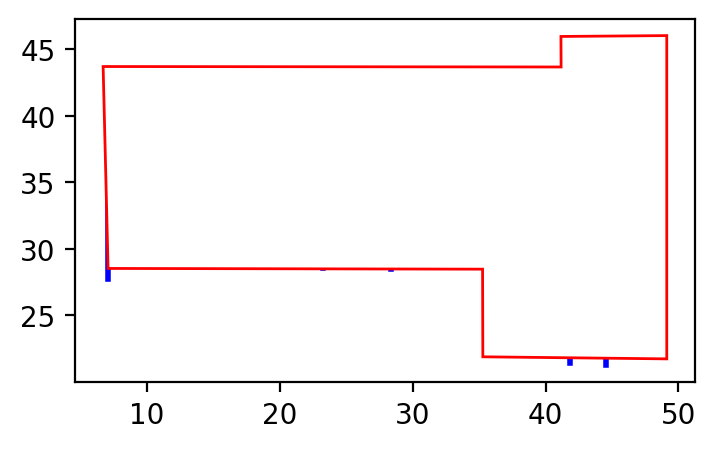

In [746]:
plot.plot_annotations(annots_by_diaphragm['diaphragm'], size=4, dpi=200)

In [747]:
# # Initialize empty lists to store x-coordinates, y-coordinates, and lengths
# x_coords = []
# y_coords = []
# lengths_ns = []

# # Loop through each annotation in the north-south wall annotations
# for annot in ns_sw_annots:
#     # Extract vertices from the annotation
#     vertices = annot.vertices
    
#     # Initial x and y are the first pair in the vertices
#     x_initial = vertices[0]
#     y_initial = vertices[1]
    
#     # Final x and y are the second pair in the vertices
#     x_final = vertices[2]
#     y_final = vertices[3]
    
#     # Calculate the length of the wall (distance between two points)
#     length = abs(y_final - y_initial)  # For north-south walls, x stays constant
    
#     # Append the extracted values to the respective lists
#     x_coords.append(x_initial)
#     y_coords.append(y_initial)
#     lengths_ns.append(length)

# # Output the extracted lists
# print("Initial X-Coordinates:", x_coords)
# print("Initial Y-Coordinates:", y_coords)
# print("Lengths:", lengths_ns)


# Initialize empty lists to store x-coordinates, y-coordinates, and lengths
x_coords = []
y_coords = []
lengths_ns = []

# Loop through each annotation in the north-south wall annotations
for annot in ns_sw_annots:
    # Extract vertices from the annotation
    vertices = annot.vertices
    
    # Extract coordinates for the two endpoints of the wall
    x1, y1 = vertices[0], vertices[1]  # First endpoint
    x2, y2 = vertices[2], vertices[3]  # Second endpoint
    
    # Determine the bottom (initial) and top (final) coordinates
    if y1 < y2:  # If y1 is smaller, it's the bottom
        x_initial, y_initial = x1, y1
        x_final, y_final = x2, y2
    else:  # Otherwise, y2 is the bottom
        x_initial, y_initial = x2, y2
        x_final, y_final = x1, y1
    
    # Calculate the length of the wall (distance between the two points)
    length = abs(y_final - y_initial)  # For north-south walls, x stays constant
    
    # Append the extracted values to the respective lists
    x_coords.append(x_initial)
    y_coords.append(y_initial)
    lengths_ns.append(length)

# Output the extracted lists
print("Initial X-Coordinates:", x_coords)
print("Initial Y-Coordinates (Bottom):", y_coords)
print("Lengths:", lengths_ns)


Initial X-Coordinates: [7.03746455698, 48.25996797778, 15.40933212, 35.93588894818, 23.232503281779998, 28.3328511024, 38.160110328600005, 41.8179922628, 44.5688120462]
Initial Y-Coordinates (Bottom): [27.709645218138, 35.668342302579994, 36.323408251, 36.613250450399995, 28.5360510864, 28.4886377568, 29.81618276338, 21.39021320462, 21.241518794106]
Lengths: [7.823230428441995, 7.8232276062200015, 5.644133555580005, 6.146771293779999, 6.217891288179999, 6.217891288180002, 5.0190396048, 5.5047581221099975, 3.8401325642939987]


In [748]:
# # Initialize empty lists to store x-coordinates, y-coordinates, and lengths
# ew_x_coords = []
# ew_y_coords = []
# lengths_ew = []

# # Loop through each annotation in the east-west wall annotations
# for annot in ew_sw_annots:
#     # Extract vertices from the annotation
#     vertices = annot.vertices
    
#     # Initial x and y are the first pair in the vertices
#     x_initial = vertices[0]
#     y_initial = vertices[1]
    
#     # Final x and y are the second pair in the vertices
#     x_final = vertices[2]
#     y_final = vertices[3]
    
#     # Calculate the length of the wall (distance between two points)
#     length = abs(x_final - x_initial)  # For east-west walls, y stays constant
    
#     # Append the extracted values to the respective lists
#     ew_x_coords.append(x_initial)
#     ew_y_coords.append(y_initial)
#     lengths_ew.append(length)

# # Output the extracted lists
# print("Initial X-Coordinates (EW Walls):", ew_x_coords)
# print("Initial Y-Coordinates (EW Walls):", ew_y_coords)
# print("Lengths (EW Walls):", lengths_ew)


# Initialize empty lists to store x-coordinates, y-coordinates, and lengths
ew_x_coords = []
ew_y_coords = []
lengths_ew = []

# Loop through each annotation in the east-west wall annotations
for annot in ew_sw_annots:
    # Extract vertices from the annotation
    vertices = annot.vertices
    
    # Extract coordinates for the two endpoints of the wall
    x1, y1 = vertices[0], vertices[1]  # First endpoint
    x2, y2 = vertices[2], vertices[3]  # Second endpoint
    
    # Determine the left (initial) and right (final) coordinates
    if x1 < x2:  # If x1 is smaller, it's the left
        x_initial, y_initial = x1, y1
        x_final, y_final = x2, y2
    else:  # Otherwise, x2 is the left
        x_initial, y_initial = x2, y2
        x_final, y_final = x1, y1
    
    # Calculate the length of the wall (distance between the two points)
    length = abs(x_final - x_initial)  # For east-west walls, y stays constant
    
    # Append the extracted values to the respective lists
    ew_x_coords.append(x_initial)
    ew_y_coords.append(y_initial)
    lengths_ew.append(length)

# Output the extracted lists
print("Initial X-Coordinates (EW Walls):", ew_x_coords)
print("Initial Y-Coordinates (EW Walls):", ew_y_coords)
print("Lengths (EW Walls):", lengths_ew)



Initial X-Coordinates (EW Walls): [41.81175515218, 20.18458818844, 27.059439136002, 33.8937573312, 42.78031352036, 25.738667462221997, 15.388986721601999]
Initial Y-Coordinates (EW Walls): [28.34636954578, 36.34497002708, 36.338930471999994, 36.338930471999994, 35.82418540142, 34.84199570098, 34.9571705808]
Lengths (EW Walls): [6.552663261820001, 5.364423133159999, 5.3644203109380015, 5.499889789160001, 5.3644231331600025, 4.680341920358, 4.273998396798003]


In [749]:
heights_ns = []

# Extract floor dimensions from Excel
# wall_height = sheet.range('J10').value  # Replace 'J12' with the actual cell for floor length
wall_height = 3.2


for idx,height_ns in enumerate(lengths_ns):
    heights_ns.append(wall_height)


##-------------------------------------------------------------------------------------------------

heights_ew = []

# Extract floor dimensions from Excel
# wall_height = sheet.range('J10').value  # Replace 'J12' with the actual cell for floor length
wall_height = 3.2


for idx,height_ns in enumerate(lengths_ew):
    heights_ew.append(wall_height)

In [750]:
# Constants
FILE_NAME = 'shearwall_data_R3.xlsx'
SHEET_NAME = 'SW_info'
LONGEST_DIM_NS_CELL = 'J10'
LONGEST_DIM_EW_CELL = 'J11'

# Workbook and Sheet Setup
wb = xw.Book(FILE_NAME)
sheet = wb.sheets[SHEET_NAME]
ws = sheet


In [751]:
# x_coords.append(x_initial)
# y_coords.append(y_initial)

# ew_x_coords.append(x_initial)
# ew_y_coords.append(y_initial)


# # Calculate the centroid of the floor
# floor_centroid_x = floor_geometry.centroid.x
# floor_centroid_y = floor_geometry.centroid.y

floor_weight = sheet.range('J23').value  # Replace 'L12' with the actual cell for floor weight (optional)
 

# Example usage with extracted wall data
# Assuming lengths_ns and heights_ns are lists of lengths and heights for NS walls
wall_weights_ns = calculate_wall_weights(lengths_ns, heights_ns)

# Assuming lengths_ew and heights_ew are lists of lengths and heights for EW walls
wall_weights_ew = calculate_wall_weights(lengths_ew, heights_ew)


# Calculate Wall Centers
y_centers_ns = calculate_wall_centers(y_coords, lengths_ns, axis='y')
x_centers_ew = calculate_wall_centers(ew_x_coords, lengths_ew, axis='x')

# Calculate CoM with Floor
com_x_with_floor = calculate_center_of_mass_with_floor(wall_weights_ns, x_centers_ew, floor_weight, floor_centroid_x)
com_y_with_floor = calculate_center_of_mass_with_floor(wall_weights_ew, y_centers_ns, floor_weight, floor_centroid_y)

print(com_x_with_floor)
print(com_y_with_floor)


30.162082489374423
34.967679396261424


In [752]:








# Calculate CoR for East-West Walls (x_cr) and North-South Walls (y_cr)
x_cr = calculate_center_of_rigidity_relative(lengths_ew, heights_ew, x_centers_ew)  # X-axis CoR from EW walls
y_cr = calculate_center_of_rigidity_relative(lengths_ns, heights_ns, y_centers_ns)  # Y-axis CoR from NS walls





# The difference between the center of mass and center of rigidity to calculate additional torsional force due to offset or eccentricity

ns_offset_list = []
for idx,length_ns in enumerate(lengths_ns):
    ns_offset_list.append(abs(com_x_with_floor-x_cr))


ew_offset_list = []
for idx,length_ns in enumerate(lengths_ew):
    ew_offset_list.append(abs(com_y_with_floor-y_cr))


ns_offset = abs(com_x_with_floor-x_cr)
ew_offset = abs(com_y_with_floor-y_cr)





# Calculate Normalized Lengths (This is actually the force component based on wall length. It will be used later to distribute the total force in each wall)
norm_lengths_ns = calculate_normalized_lengths(lengths_ns)
norm_lengths_ew = calculate_normalized_lengths(lengths_ew)





# Calculate Torsion and Rigidity Values
longest_dim_ns = sheet.range(LONGEST_DIM_NS_CELL).value
longest_dim_ew = sheet.range(LONGEST_DIM_EW_CELL).value

m_tor_ns = calculate_m_torsion(lengths_ns, longest_dim_ns)
m_tor_ew = calculate_m_torsion(lengths_ew, longest_dim_ew)


# Element-wise addition for NS
total_m_tor_ns = [m + offset for m, offset in zip(m_tor_ns, ns_offset_list)]

# Element-wise addition for EW
total_m_tor_ew = [m + offset for m, offset in zip(m_tor_ew, ew_offset_list)]



total_m_tor_ns

[22.275297349162116,
 22.275297349162116,
 22.275297349162116,
 22.275297349162116,
 22.275297349162116,
 22.275297349162116,
 22.275297349162116,
 22.275297349162116,
 22.275297349162116]

In [753]:


d_x_ns, Jpx = calculate_rigidity(lengths_ns, x_coords, com_x_with_floor)
d_y_ew, Jpy = calculate_rigidity(lengths_ew, ew_y_coords, com_y_with_floor)




# Calculate V_total for NS and EW directions
V_total_ns_list = calculate_v_total(norm_lengths_ns, m_tor_ns, d_x_ns, Jpx)
V_total_ew_list = calculate_v_total(norm_lengths_ew, m_tor_ew, d_y_ew, Jpy)
V_total_ns_list
V_total_ew_list

[0.3072392625670833,
 0.1717627613656428,
 0.1716435431807436,
 0.17529499585430053,
 0.1614892593102653,
 0.12863358320104518,
 0.11540892353902278]

# Plot wall and floor data

In [754]:
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon

# Plotting function for walls
def plot_walls(ax, walls, color, label_prefix):
    """
    Plots the walls with the given color and label prefix.
    
    Parameters:
    - ax: Matplotlib axis object.
    - walls: List of Annotation objects containing vertices.
    - color: Color to use for plotting the walls.
    - label_prefix: Prefix for the legend label.
    """
    for idx, wall in enumerate(walls):
        # Extract vertices from the Annotation object
        vertices = wall.vertices
        x_initial, y_initial = vertices[0], vertices[1]
        x_final, y_final = vertices[2], vertices[3]

        if label_prefix == 'NS':  # North-South walls (vertical lines)
            ax.plot([x_initial, x_final], [y_initial, y_final], color=color, linewidth=2,
                    label=f'{label_prefix} Wall' if idx == 0 else "")
        elif label_prefix == 'EW':  # East-West walls (horizontal lines)
            ax.plot([x_initial, x_final], [y_initial, y_final], color=color, linewidth=3,
                    label=f'{label_prefix} Wall' if idx == 0 else "")

# Calculate floor geometry and centroid
floor_shapes = annotations.annotations_to_shapely(floor_annots)
floor_geometry = MultiPolygon(floor_shapes)
floor_centroid_x = floor_geometry.centroid.x
floor_centroid_y = floor_geometry.centroid.y



In [755]:
# Plot the roof diaphragm multipolygon with shear wall layout
fig, ax = plt.subplots(figsize=(8, 6))

# # Plot the shear walls
# plot_shear_wall_layout(ax, x_ns, y_ns, lengths_ns, color='blue', label_prefix='NS')
# plot_shear_wall_layout(ax, x_ew, y_ew, lengths_ew, color='red', label_prefix='EW')

# Plot North-South walls
plot_walls(ax, ns_sw_annots, color='green', label_prefix='NS')

# Plot East-West walls
plot_walls(ax, ew_sw_annots, color='orange', label_prefix='EW')


# Plot the floor geometry
for geom in floor_geometry.geoms:
    x, y = geom.exterior.xy
    ax.plot(x, y, color='blue', linewidth=2, label='Floor')

# Plot the floor centroid
ax.scatter(floor_centroid_x, floor_centroid_y, color='red', s=100, label='Floor Centroid')

# # Plot the roof diaphragm multipolygon
# for geom in multi_polygon.geoms:  # Handle each polygon in the MultiPolygon
#     x, y = geom.exterior.xy  # Get exterior coordinates
#     ax.plot(x, y, color='purple', linewidth=2, label='Roof Diaphragm')  # Plot the outline

# # Plot the centroid of the multipolygon
# ax.scatter(centroid_x, centroid_y, color='purple', s=100, label='Roof Centroid')

# Plot CoM and CoR
ax.scatter(com_x_with_floor, com_y_with_floor, color='green', s=100, label='CoM')
ax.scatter(x_cr, y_cr, color='orange', s=100, label='CoR')

# Annotate Roof Centroid
ax.text(floor_centroid_x, floor_centroid_y, f'Centroid ({floor_centroid_x:.2f}, {floor_centroid_y:.2f})',
        fontsize=10, color='purple', ha='left', va='bottom')

# Annotate CoM
ax.text(com_x_with_floor, com_y_with_floor, f'CoM ({com_x_with_floor:.2f}, {com_y_with_floor:.2f})',
        fontsize=9, color='green', ha='right', va='bottom')

# Annotate CoR
ax.text(x_cr, y_cr, f'CoR ({x_cr:.2f}, {y_cr:.2f})',
        fontsize=9, color='orange', ha='right', va='bottom')

# Formatting the plot
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Shear Wall Layout with Roof Diaphragm and Centroid')
# ax.legend()
ax.grid(True)
ax.axis('equal')

# Embed the plot into Excel
ws.pictures.add(fig, name='RoofDiaphragmShearWallPlot', update=True, anchor=ws.range('C64'))
plt.show()

In [756]:
# # Visualization
# fig, ax = plt.subplots(figsize=(10, 8))

# # Plot the floor geometry
# for geom in floor_geometry.geoms:
#     x, y = geom.exterior.xy
#     ax.plot(x, y, color='blue', linewidth=2, label='Floor')

# # # Plot the floor centroid
# # ax.scatter(floor_centroid_x, floor_centroid_y, color='red', s=100, label='Floor Centroid')

# # Plot the floor centroid
# ax.scatter(com_x_with_floor, com_y_with_floor, color='red', s=100, label='Floor Centroid')

# # Plot North-South walls
# plot_walls(ax, ns_sw_annots, color='green', label_prefix='NS')

# # Plot East-West walls
# plot_walls(ax, ew_sw_annots, color='orange', label_prefix='EW')

# # Annotate the floor centroid
# ax.text(floor_centroid_x, floor_centroid_y, f'Floor Centroid ({floor_centroid_x:.2f}, {floor_centroid_y:.2f})',
#         fontsize=10, color='red', ha='left', va='bottom')

# # Formatting the plot
# ax.set_xlabel('X Coordinate')
# ax.set_ylabel('Y Coordinate')
# ax.set_title('Floor Geometry and Shear Walls')
# ax.legend()
# ax.grid(True)
# ax.axis('equal')



# # Embed the plot into Excel
# ws.pictures.add(fig, name='RoofDiaphragmShearWallPlot', update=True, anchor=ws.range('C64'))
# plt.show()


In [757]:

#----------------------------------------------------------------------------------------------------------------------------
# All output results to excel
#----------------------------------------------------------------------------------------------------------------------------


#--------------------------------------------------------------------------------
# Output results to Excel
#--------------------------------------------------------------------------------
sheet.range('J13').value = com_x_with_floor
sheet.range('J14').value = com_y_with_floor


sheet.range('J16').value = x_cr  # X-coordinate of Center of Rigidity
sheet.range('J17').value = y_cr  # Y-coordinate of Center of Rigidity


# Output CoR results to Excel
sheet.range('N13').value = ns_offset  # X-coordinate of Center of Rigidity
sheet.range('N14').value = ew_offset  # Y-coordinate of Center of Rigidity


# Output Normalized Lengths to Excel
sheet.range('J29').options(transpose=True).value = norm_lengths_ns
sheet.range('V29').options(transpose=True).value = norm_lengths_ew


sheet.range('K29').options(transpose=True).value = total_m_tor_ns
sheet.range('W29').options(transpose=True).value = total_m_tor_ew


sheet.range('I29').options(transpose=True).value = d_x_ns
sheet.range('U29').options(transpose=True).value = d_y_ew
sheet.range('J19').value = Jpx
sheet.range('J20').value = Jpy

# Output V_total Results to Excel
sheet.range('L29').options(transpose=True).value = V_total_ns_list
sheet.range('X29').options(transpose=True).value = V_total_ew_list


#--------------------------------------------------------------------------------
# Populate the table data (NS direction data)
#--------------------------------------------------------------------------------

sheet.range('E29').options(transpose=True).value = lengths_ns
sheet.range('F29').options(transpose=True).value = heights_ns
sheet.range('G29').options(transpose=True).value = x_coords
sheet.range('H29').options(transpose=True).value = y_coords

#--------------------------------------------------------------------------------
# Populate the table data (NS direction data)
#--------------------------------------------------------------------------------

sheet.range('Q29').options(transpose=True).value = lengths_ew
sheet.range('R29').options(transpose=True).value = heights_ew
sheet.range('S29').options(transpose=True).value = ew_x_coords
sheet.range('T29').options(transpose=True).value = ew_y_coords


